# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

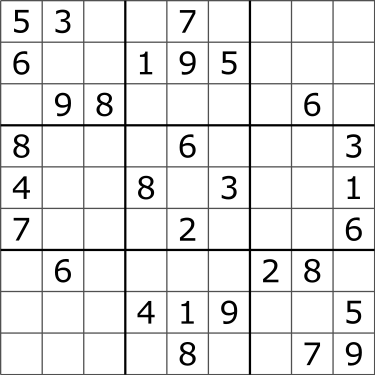

## Prepare environment

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers, losses, metrics, models
import pathlib
from matplotlib import pyplot as plt

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

2025-04-23 10:22:02.752574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745396522.784524   50917 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745396522.793068   50917 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 10:22:02.826021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameters

In [2]:
BATCH_SIZE = 128 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3

## Prepare dataset

### Download from Kaggle

In [3]:
path = kagglehub.dataset_download("rohanrao/sudoku")
print("Path to dataset files:", path)

Path to dataset files: /home/martin/.cache/kagglehub/datasets/rohanrao/sudoku/versions/1


In [4]:
os.listdir(path)

['sudoku.csv']

In [5]:
FILE_PATH = os.path.join(path, "sudoku.csv")

In [6]:
sudoku_text = pathlib.Path(FILE_PATH).read_text()

In [7]:
sudoku_lines = sudoku_text.split("\n")[1:-1]  # Drop header

In [8]:
# TODO: remove - Limit data size to be able to run locally
sudoku_lines = sudoku_lines[:90_000]

In [9]:
full_dataset_size = len(sudoku_lines)
print(full_dataset_size)

90000


### Load as Tensors

In [10]:
sudoku_tensors = tf.io.decode_csv(sudoku_lines, record_defaults=[str()]*2) 

I0000 00:00:1745396535.020388   50917 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [11]:
print(f"{len(sudoku_tensors), len(sudoku_tensors[0])}")

(2, 90000)


In [12]:
sudoku_transposed_tensors = tf.transpose(sudoku_tensors)

In [13]:
print(f"{len(sudoku_transposed_tensors), len(sudoku_transposed_tensors[0])}")

(90000, 2)


In [14]:
sudoku_ds = tf.data.Dataset.from_tensor_slices(sudoku_transposed_tensors)
sudoku_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(2,), dtype=tf.string, name=None)>

In [15]:
for puzzle, solution in sudoku_ds.take(1):
    print(puzzle, solution)

tf.Tensor(b'070000043040009610800634900094052000358460020000800530080070091902100005007040802', shape=(), dtype=string) tf.Tensor(b'679518243543729618821634957794352186358461729216897534485276391962183475137945862', shape=(), dtype=string)


2025-04-23 10:22:15.440608: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Preprocess

In [16]:
@tf.function
def preprocess(puzzle_tensor):
    puzzle_with_spaces = tf.strings.regex_replace(puzzle_tensor, "", " ")
    puzzle_chars = tf.strings.split(puzzle_with_spaces)
    puzzle_numbers = tf.strings.to_number(puzzle_chars, out_type=tf.int32)
    return tf.reshape(puzzle_numbers, (9, 9, 1))

@tf.function
def preprocess_input(puzzle_tensor):
    return (preprocess(puzzle_tensor) / 9) - 0.5

@tf.function
def preprocess_target(puzzle_tensor):
    return preprocess(puzzle_tensor) - 1 # 0-based predictions (when presenting results, do not forget to add +1)

In [17]:
sudoku_reshaped_ds = sudoku_ds.map(lambda row: (preprocess_input(row[0]), preprocess_target(row[1])), num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
for row in sudoku_reshaped_ds.take(1):
    print(f"{len(row), len(row[0]), len(row[0][0])}\n")
    print(f"puzzle:\n{row[0]}\n")
    print(f"solution:\n{row[1]}\n")

(2, 9, 9)

puzzle:
[[[-0.5       ]
  [ 0.27777778]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.05555556]
  [-0.16666667]]

 [[-0.5       ]
  [-0.05555556]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [ 0.5       ]
  [ 0.16666667]
  [-0.38888889]
  [-0.5       ]]

 [[ 0.38888889]
  [-0.5       ]
  [-0.5       ]
  [ 0.16666667]
  [-0.16666667]
  [-0.05555556]
  [ 0.5       ]
  [-0.5       ]
  [-0.5       ]]

 [[-0.5       ]
  [ 0.5       ]
  [-0.05555556]
  [-0.5       ]
  [ 0.05555556]
  [-0.27777778]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]]

 [[-0.16666667]
  [ 0.05555556]
  [ 0.38888889]
  [-0.05555556]
  [ 0.16666667]
  [-0.5       ]
  [-0.5       ]
  [-0.27777778]
  [-0.5       ]]

 [[-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [ 0.38888889]
  [-0.5       ]
  [-0.5       ]
  [ 0.05555556]
  [-0.16666667]
  [-0.5       ]]

 [[-0.5       ]
  [ 0.38888889]
  [-0.5       ]
  [-0.5       ]
  [ 0.27777778]
  [-0.5       ]
  [-0.5  

2025-04-23 10:22:15.744158: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Build input pipeline for performance

In [19]:
def configure_for_performance(ds, shuffle = False):
  ds = ds.cache()
  if (shuffle):
    # Since full size is 9M, let's use at least 1M for shuffling buffer (lower when memory is an issue)
    ds = ds.shuffle(buffer_size=1_000_000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [20]:
train_size = int(0.8 * full_dataset_size)
val_size = int(0.1 * full_dataset_size)
test_size = int(0.1 * full_dataset_size)

train_dataset = sudoku_reshaped_ds.take(train_size)
test_dataset = sudoku_reshaped_ds.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

train_dataset = configure_for_performance(train_dataset, shuffle=True)
val_dataset = configure_for_performance(val_dataset, shuffle=True)
test_dataset = configure_for_performance(test_dataset, shuffle=False)

## Train model

In [21]:
inputs = layers.Input((9, 9, 1))

# First Conv2D block
x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
# Second Conv2D block
x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
# Third Conv2D block
x = layers.Conv2D(128, kernel_size=1, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# Incorporate Sudoku structure awareness
# Row awareness
row_conv = layers.Conv2D(32, kernel_size=(1, 9), padding="same")(x)
# Column awareness  
col_conv = layers.Conv2D(32, kernel_size=(9, 1), padding="same")(x)
# Box awareness (3x3 boxes with dilation)
box_conv = layers.Conv2D(32, kernel_size=3, padding="same", dilation_rate=3)(x)

# Combine structure-aware features
x = layers.Concatenate()([x, row_conv, col_conv, box_conv])
x = layers.Conv2D(256, kernel_size=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
    
# Final prediction layers
x = layers.Flatten()(x)
x = layers.Dense(9 * 9 * 9)(x)
x = layers.Reshape((9, 9, 9))(x)
outputs = layers.Softmax()(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 128) │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 32)  │     36,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 32)  │     36,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 9, 9, 32)  │     36,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9, 9, 224) │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 9, 9, 256) │     57,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 256) │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20736)     │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 729)       │ 15,117,273 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 9, 9, 9)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 9, 9, 9)   │          0 │ reshape[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,333,497 (58.49 MB)

 Trainable params: 15,332,473 (58.49 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [22]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=1)

I0000 00:00:1745396544.827296   51158 service.cc:148] XLA service 0x7f5538004130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745396544.827374   51158 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-23 10:22:24.913761: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745396545.093036   51158 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1745396545.309181   51158 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-04-23 10:22:25.987170: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[128,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,

  3/563 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.1098 - loss: 4.4444 

I0000 00:00:1745396555.006687   51158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2629 - loss: 2.4503

W0000 00:00:1745396584.495464   51159 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-23 10:23:04.962858: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-23 10:23:05.971718: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[576,32,3,3]{3,2,1,0}, u8[0]{0}) custom

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2632 - loss: 2.4487

W0000 00:00:1745396595.199311   51158 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-23 10:23:15.526835: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[128,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
W0000 00:00:1745396597.881557   51157 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-23

563/563 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.2635 - loss: 2.4472 - val_accuracy: 0.3367 - val_loss: 1.7856


In [23]:
MODEL_FILE_NAME = "sudoku_solver.keras"
model.save(MODEL_FILE_NAME)

## Evaluate model

In [24]:
model = keras.saving.load_model(MODEL_FILE_NAME)

In [25]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [26]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [27]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [28]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

2025-04-23 10:23:22.223217: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-23 10:23:22.999012: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[9,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,128,5,5]{3,2,1,0}, f32[32,128,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudn

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[8 9 5 2 4 6 7 1 3]
 [4 2 5 4 6 9 8 9 2]
 [6 2 2 3 3 8 2 6 4]
 [6 6 2 6 3 4 2 7 6]
 [9 8 3 5 6 2 1 3 7]
 [2 5 7 8 1 9 4 4 5]
 [4 3 6 7 8 2 6 2 2]
 [6 6 2 3 2 2 5 7 8]
 [2 7 8 4 7 6 4 4 1]]


In [29]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1745396604.595779   51159 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3827 - loss: 1.7804


In [30]:
loss, accuracy = model.evaluate(test_dataset)

W0000 00:00:1745396609.459125   51155 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3366 - loss: 1.7881

W0000 00:00:1745396611.195925   51155 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3366 - loss: 1.7879


In [31]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.33711662888526917 and loss: 1.7857376337051392


The End